# Imports and Functions

In [1]:
import math 
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 2 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

global threshold_low
global threshold_high
threshold_low = -500
threshold_high = 0

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-512+(((x+5)*(512--512))/(51+5)))
def ynew(y): 
    return (-512+(((y+2)*(512--512))/(53+2)))

def eggholder(x):
       
    return (-(x[1]+47)*(math.sin(math.sqrt(abs((x[0]/2)+(x[1]+47))))))-((x[0])*(math.sin(math.sqrt(abs((x[0])+(x[1]+47))))))

def eggholderColor(x, threshold_low, threshold_high):
    
    if threshold_low < eggholder((xnew(x[0]),xnew(x[1]))) <threshold_high:
        return 1
    else:
        return 0

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zeggholder
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zeggholder = []
    eggholdercoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zeggholder.append(eggholderColor(eggholdercoords[i],threshold_low,threshold_high))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zeggholder)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist())-1)
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


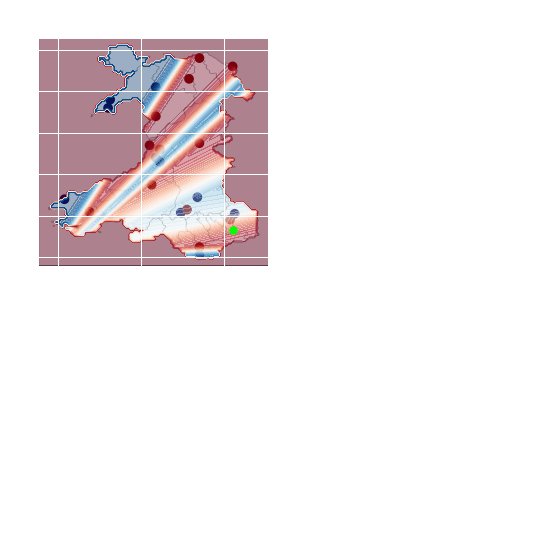

iteration  1
Accuracy is 0.50432609113632
iteration  2
Accuracy is 0.5047106325706595
iteration  3
Accuracy is 0.50432609113632
iteration  4
Accuracy is 0.5074024226110363
iteration  5
Accuracy is 0.5141318977119784
iteration  6
Accuracy is 0.5160546048836763
iteration  7
Accuracy is 0.5322053451259373
iteration  8
Accuracy is 0.5337435108632955
iteration  9
Accuracy is 0.5193232070755623
iteration  10
Accuracy is 0.5283599307825418
iteration  11
Accuracy is 0.5323976158431071
iteration  12
Accuracy is 0.5356662180349933
iteration  13
Accuracy is 0.5425879638531051
iteration  14
Accuracy is 0.5439338588732936
iteration  15
Accuracy is 0.5427802345702749
iteration  16
Accuracy is 0.5297058258027303
iteration  17
Accuracy is 0.5345125937319746
iteration  18
Accuracy is 0.535089405883484
iteration  19
Accuracy is 0.5356662180349933
iteration  20
Accuracy is 0.5314362622572583
iteration  21
Accuracy is 0.5385502787925399
experiment:  1


<IPython.core.display.Javascript object>


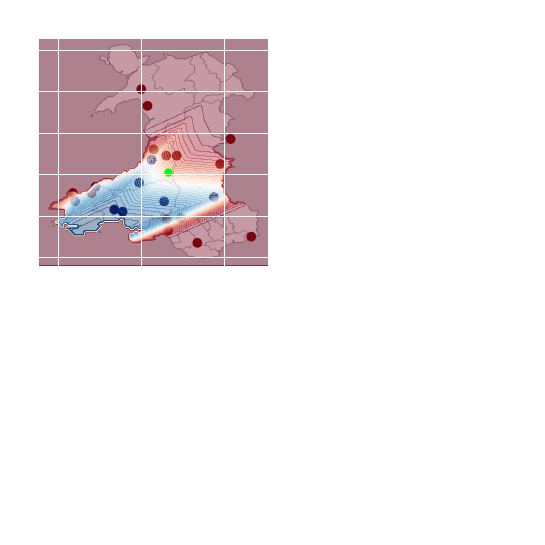

iteration  1
Accuracy is 0.5370121130551817
iteration  2
Accuracy is 0.5273985771966929
iteration  3
Accuracy is 0.5270140357623534
iteration  4
Accuracy is 0.5289367429340511
iteration  5
Accuracy is 0.5206691020957508
iteration  6
Accuracy is 0.5210536435300903
iteration  7
Accuracy is 0.49778888675254757
iteration  8
Accuracy is 0.5200922899442415
iteration  9
Accuracy is 0.5212459142472602
iteration  10
Accuracy is 0.533358969428956
iteration  11
Accuracy is 0.5175927706210344
iteration  12
Accuracy is 0.5199000192270717
iteration  13
Accuracy is 0.5223995385502788
iteration  14
Accuracy is 0.5139396269948087
iteration  15
Accuracy is 0.5135550855604691
iteration  16
Accuracy is 0.520476831378581
iteration  17
Accuracy is 0.5125937319746202
iteration  18
Accuracy is 0.5172082291866948
iteration  19
Accuracy is 0.5191309363583926
iteration  20
Accuracy is 0.5189386656412228
iteration  21
Accuracy is 0.5149009805806576
experiment:  2


<IPython.core.display.Javascript object>


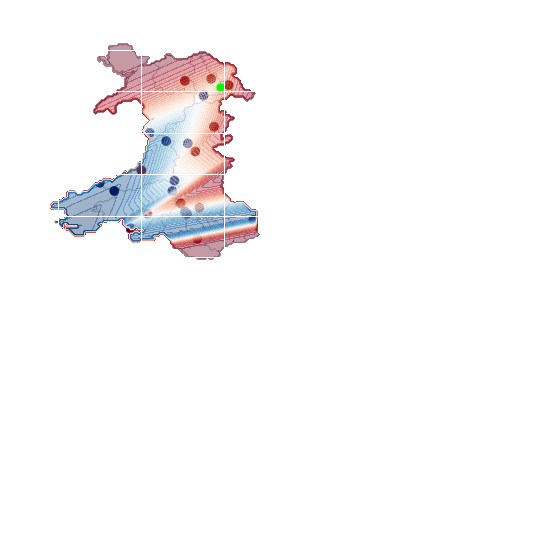

iteration  1
Accuracy is 0.49452028456066144
iteration  2
Accuracy is 0.49951932320707554
iteration  3
Accuracy is 0.49452028456066144
iteration  4
Accuracy is 0.4947125552778312
iteration  5
Accuracy is 0.5027879253989618
iteration  6
Accuracy is 0.5385502787925399
iteration  7
Accuracy is 0.5322053451259373
iteration  8
Accuracy is 0.5422034224187656
iteration  9
Accuracy is 0.5550855604691406
iteration  10
Accuracy is 0.506056527590848
iteration  11
Accuracy is 0.5216304556815997
iteration  12
Accuracy is 0.5223995385502788
iteration  13
Accuracy is 0.519707748509902
iteration  14
Accuracy is 0.5237454335704672
iteration  15
Accuracy is 0.5229763507017882
iteration  16
Accuracy is 0.5335512401461258
iteration  17
Accuracy is 0.535089405883484
iteration  18
Accuracy is 0.5262449528936743
iteration  19
Accuracy is 0.5245145164391464
iteration  20
Accuracy is 0.5418188809844261
iteration  21
Accuracy is 0.5254758700249952
experiment:  3


<IPython.core.display.Javascript object>


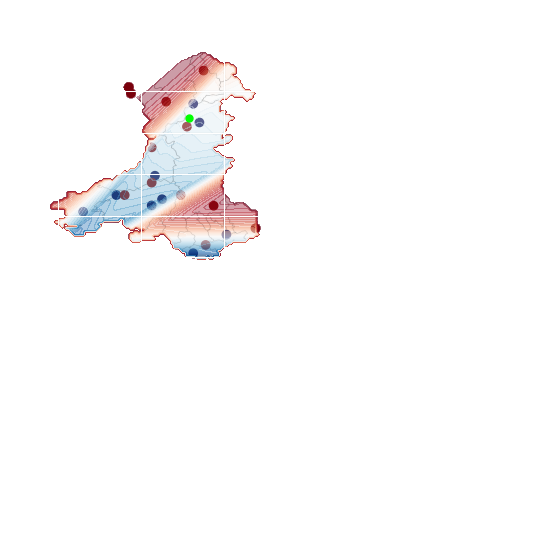

iteration  1
Accuracy is 0.5022111132474524
iteration  2
Accuracy is 0.4975966160353778
iteration  3
Accuracy is 0.5024033839646221
iteration  4
Accuracy is 0.5016343010959431
iteration  5
Accuracy is 0.5022111132474524
iteration  6
Accuracy is 0.4845222072678331
iteration  7
Accuracy is 0.4877908094597193
iteration  8
Accuracy is 0.49855796962122667
iteration  9
Accuracy is 0.4839453951163238
iteration  10
Accuracy is 0.4860603730051913
iteration  11
Accuracy is 0.4891367044799077
iteration  12
Accuracy is 0.4927898481061334
iteration  13
Accuracy is 0.502595654681792
iteration  14
Accuracy is 0.4979811574697174
iteration  15
Accuracy is 0.499134781772736
iteration  16
Accuracy is 0.49202076523745436
iteration  17
Accuracy is 0.49778888675254757
iteration  18
Accuracy is 0.5202845606614113
iteration  19
Accuracy is 0.5135550855604691
iteration  20
Accuracy is 0.5072101518938665
iteration  21
Accuracy is 0.5045183618534897
experiment:  4


<IPython.core.display.Javascript object>


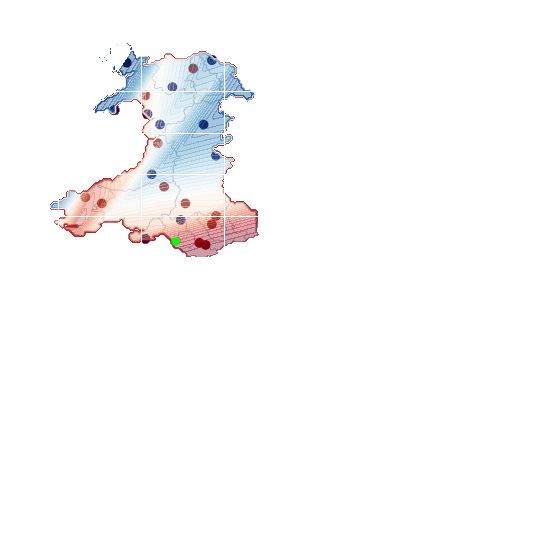

iteration  1
Accuracy is 0.5187463949240531
iteration  2
Accuracy is 0.5220149971159392
iteration  3
Accuracy is 0.5331666987117862
iteration  4
Accuracy is 0.5264372236108441
iteration  5
Accuracy is 0.5208613728129206
iteration  6
Accuracy is 0.5327821572774466
iteration  7
Accuracy is 0.525668140742165
iteration  8
Accuracy is 0.5233608921361277
iteration  9
Accuracy is 0.5241299750048067
iteration  10
Accuracy is 0.5202845606614113
iteration  11
Accuracy is 0.5045183618534897
iteration  12
Accuracy is 0.5058642568736781
iteration  13
Accuracy is 0.508556046914055
iteration  14
Accuracy is 0.49778888675254757
iteration  15
Accuracy is 0.48086906364160736
iteration  16
Accuracy is 0.4860603730051913
iteration  17
Accuracy is 0.4802922514900981
iteration  18
Accuracy is 0.48086906364160736
iteration  19
Accuracy is 0.4883676216112286
iteration  20
Accuracy is 0.49951932320707554
iteration  21
Accuracy is 0.49009805806575657
experiment:  5


<IPython.core.display.Javascript object>


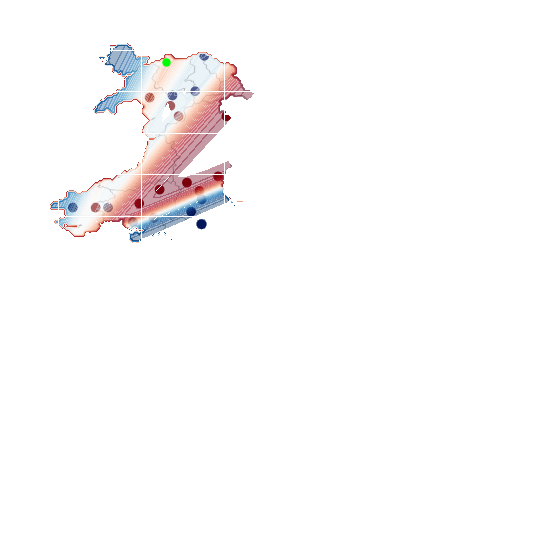

iteration  1
Accuracy is 0.47510094212651416
iteration  2
Accuracy is 0.49740434531820804
iteration  3
Accuracy is 0.5037492789848106
iteration  4
Accuracy is 0.4983656989040569
iteration  5
Accuracy is 0.49971159392424536
iteration  6
Accuracy is 0.5000961353585849
iteration  7
Accuracy is 0.5002884060757546
iteration  8
Accuracy is 0.5079792347625457
iteration  9
Accuracy is 0.5054797154393386
iteration  10
Accuracy is 0.5281676600653721
iteration  11
Accuracy is 0.5237454335704672
iteration  12
Accuracy is 0.5272063064795232
iteration  13
Accuracy is 0.5241299750048067
iteration  14
Accuracy is 0.5200922899442415
iteration  15
Accuracy is 0.5160546048836763
iteration  16
Accuracy is 0.5027879253989618
iteration  17
Accuracy is 0.5164391463180158
iteration  18
Accuracy is 0.5129782734089599
iteration  19
Accuracy is 0.5035570082676408
iteration  20
Accuracy is 0.5135550855604691
iteration  21
Accuracy is 0.5172082291866948
experiment:  6


<IPython.core.display.Javascript object>


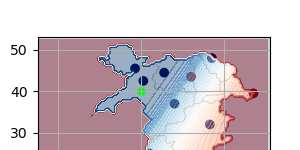

iteration  1
Accuracy is 0.5323976158431071
iteration  2
Accuracy is 0.5039415497019804
iteration  3
Accuracy is 0.5039415497019804
iteration  4
Accuracy is 0.5108632955200922
iteration  5
Accuracy is 0.5110555662372621
iteration  6
Accuracy is 0.5125937319746202
iteration  7
Accuracy is 0.5002884060757546
iteration  8
Accuracy is 0.5070178811766968
iteration  9
Accuracy is 0.5177850413382042
iteration  10
Accuracy is 0.49375120169198233
iteration  11
Accuracy is 0.5072101518938665
iteration  12
Accuracy is 0.4947125552778312
iteration  13
Accuracy is 0.5212459142472602
iteration  14
Accuracy is 0.5174004999038646
iteration  15
Accuracy is 0.510286483368583
iteration  16
Accuracy is 0.5158623341665064
iteration  17
Accuracy is 0.5064410690251875
iteration  18
Accuracy is 0.5129782734089599
iteration  19
Accuracy is 0.5095174004999039
iteration  20
Accuracy is 0.49894251105556625
iteration  21
Accuracy is 0.5200922899442415
experiment:  7


<IPython.core.display.Javascript object>


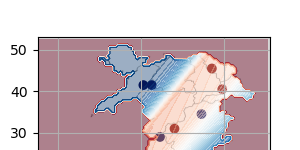

iteration  1
Accuracy is 0.46837146702557203
iteration  2
Accuracy is 0.4591424726014228
iteration  3
Accuracy is 0.48009998077292826
iteration  4
Accuracy is 0.4975966160353778
iteration  5
Accuracy is 0.48567583157085176
iteration  6
Accuracy is 0.48894443376273794
iteration  7
Accuracy is 0.4877908094597193
iteration  8
Accuracy is 0.4968275331666987
iteration  9
Accuracy is 0.4924053066717939
iteration  10
Accuracy is 0.4947125552778312
iteration  11
Accuracy is 0.4899057873485868
iteration  12
Accuracy is 0.4862526437223611
iteration  13
Accuracy is 0.4839453951163238
iteration  14
Accuracy is 0.49048259950009615
iteration  15
Accuracy is 0.48932897519707746
iteration  16
Accuracy is 0.49586617958084983
iteration  17
Accuracy is 0.4939434724091521
iteration  18
Accuracy is 0.48183041722745623
iteration  19
Accuracy is 0.49375120169198233
iteration  20
Accuracy is 0.4887521630455682
iteration  21
Accuracy is 0.5133628148432994
experiment:  8


<IPython.core.display.Javascript object>


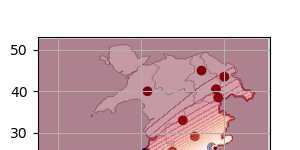

iteration  1
Accuracy is 0.5062487983080177
iteration  2
Accuracy is 0.5037492789848106
iteration  3
Accuracy is 0.5029801961161315
iteration  4
Accuracy is 0.47644683714670255
iteration  5
Accuracy is 0.499134781772736
iteration  6
Accuracy is 0.49567390886368007
iteration  7
Accuracy is 0.49663526244952894
iteration  8
Accuracy is 0.5049029032878293
iteration  9
Accuracy is 0.5047106325706595
iteration  10
Accuracy is 0.5056719861565083
iteration  11
Accuracy is 0.5006729475100942
iteration  12
Accuracy is 0.5100942126514132
iteration  13
Accuracy is 0.5093251297827341
iteration  14
Accuracy is 0.5064410690251875
iteration  15
Accuracy is 0.5223995385502788
iteration  16
Accuracy is 0.5137473562776389
iteration  17
Accuracy is 0.5189386656412228
iteration  18
Accuracy is 0.5183618534897135
iteration  19
Accuracy is 0.5181695827725438
iteration  20
Accuracy is 0.5133628148432994
iteration  21
Accuracy is 0.5114401076716016
experiment:  9


<IPython.core.display.Javascript object>


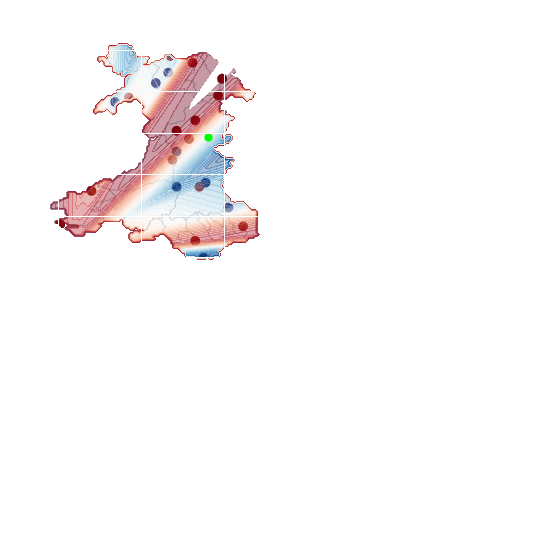

iteration  1
Accuracy is 0.5329744279946165
iteration  2
Accuracy is 0.5454720246106518
iteration  3
Accuracy is 0.5312439915400884
iteration  4
Accuracy is 0.5212459142472602
iteration  5
Accuracy is 0.5154777927321669
iteration  6
Accuracy is 0.5200922899442415
iteration  7
Accuracy is 0.5149009805806576
iteration  8
Accuracy is 0.5218227263987695
iteration  9
Accuracy is 0.5298980965199
iteration  10
Accuracy is 0.5297058258027303
iteration  11
Accuracy is 0.5279753893482023
iteration  12
Accuracy is 0.5177850413382042
iteration  13
Accuracy is 0.5154777927321669
iteration  14
Accuracy is 0.5275908479138627
iteration  15
Accuracy is 0.5174004999038646
iteration  16
Accuracy is 0.5202845606614113
iteration  17
Accuracy is 0.5054797154393386
iteration  18
Accuracy is 0.49855796962122667
iteration  19
Accuracy is 0.5160546048836763
iteration  20
Accuracy is 0.5172082291866948
iteration  21
Accuracy is 0.5322053451259373
experiment:  10


<IPython.core.display.Javascript object>


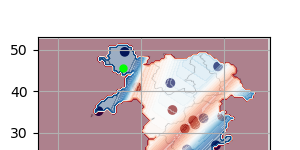

iteration  1
Accuracy is 0.4843299365506633
iteration  2
Accuracy is 0.483753124399154
iteration  3
Accuracy is 0.49202076523745436
iteration  4
Accuracy is 0.4916362238031148
iteration  5
Accuracy is 0.4943280138434916
iteration  6
Accuracy is 0.46721784272255334
iteration  7
Accuracy is 0.48086906364160736
iteration  8
Accuracy is 0.4814458757931167
iteration  9
Accuracy is 0.48202268794462605
iteration  10
Accuracy is 0.48567583157085176
iteration  11
Accuracy is 0.4870217265910402
iteration  12
Accuracy is 0.493174389540473
iteration  13
Accuracy is 0.5016343010959431
iteration  14
Accuracy is 0.5010574889444338
iteration  15
Accuracy is 0.5016343010959431
iteration  16
Accuracy is 0.4924053066717939
iteration  17
Accuracy is 0.5077869640453759
iteration  18
Accuracy is 0.476062295712363
iteration  19
Accuracy is 0.48855989232839836
iteration  20
Accuracy is 0.47971543933858873
iteration  21
Accuracy is 0.4883676216112286
experiment:  11


<IPython.core.display.Javascript object>


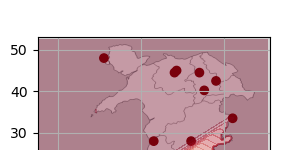

iteration  1
Accuracy is 0.4983656989040569
iteration  2
Accuracy is 0.49778888675254757
iteration  3
Accuracy is 0.5056719861565083
iteration  4
Accuracy is 0.5189386656412228
iteration  5
Accuracy is 0.506056527590848
iteration  6
Accuracy is 0.5227840799846183
iteration  7
Accuracy is 0.5223995385502788
iteration  8
Accuracy is 0.5052874447221688
iteration  9
Accuracy is 0.5054797154393386
iteration  10
Accuracy is 0.5193232070755623
iteration  11
Accuracy is 0.5191309363583926
iteration  12
Accuracy is 0.519707748509902
iteration  13
Accuracy is 0.5199000192270717
iteration  14
Accuracy is 0.5195154777927322
iteration  15
Accuracy is 0.49817342818688715
iteration  16
Accuracy is 0.5081715054797155
iteration  17
Accuracy is 0.5033647375504711
iteration  18
Accuracy is 0.508556046914055
iteration  19
Accuracy is 0.5191309363583926
iteration  20
Accuracy is 0.5152855220149971
iteration  21
Accuracy is 0.5099019419342434
experiment:  12


<IPython.core.display.Javascript object>


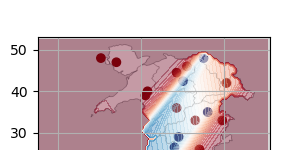

iteration  1
Accuracy is 0.4729859642376466
iteration  2
Accuracy is 0.48163814651028647
iteration  3
Accuracy is 0.5045183618534897
iteration  4
Accuracy is 0.5031724668333013
iteration  5
Accuracy is 0.502595654681792
iteration  6
Accuracy is 0.5022111132474524
iteration  7
Accuracy is 0.506825610459527
iteration  8
Accuracy is 0.505095174004999
iteration  9
Accuracy is 0.5083637761968852
iteration  10
Accuracy is 0.5385502787925399
iteration  11
Accuracy is 0.5272063064795232
iteration  12
Accuracy is 0.5339357815804653
iteration  13
Accuracy is 0.5454720246106518
iteration  14
Accuracy is 0.5293212843683907
iteration  15
Accuracy is 0.5352816766006537
iteration  16
Accuracy is 0.5174004999038646
iteration  17
Accuracy is 0.5362430301865025
iteration  18
Accuracy is 0.519707748509902
iteration  19
Accuracy is 0.5416266102672563
iteration  20
Accuracy is 0.5087483176312247
iteration  21
Accuracy is 0.5131705441261296
experiment:  13


<IPython.core.display.Javascript object>


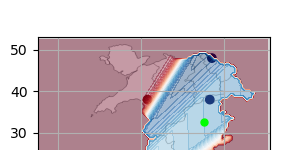

iteration  1
Accuracy is 0.5012497596616036
iteration  2
Accuracy is 0.5006729475100942
iteration  3
Accuracy is 0.47433185925783505
iteration  4
Accuracy is 0.47029417419726977
iteration  5
Accuracy is 0.493174389540473
iteration  6
Accuracy is 0.4862526437223611
iteration  7
Accuracy is 0.4576043068640646
iteration  8
Accuracy is 0.4785618150355701
iteration  9
Accuracy is 0.47317823495481637
iteration  10
Accuracy is 0.4843299365506633
iteration  11
Accuracy is 0.48259950009613534
iteration  12
Accuracy is 0.4822149586617958
iteration  13
Accuracy is 0.47413958854066524
iteration  14
Accuracy is 0.48086906364160736
iteration  15
Accuracy is 0.47721592001538166
iteration  16
Accuracy is 0.47567775427802345
iteration  17
Accuracy is 0.47567775427802345
iteration  18
Accuracy is 0.477792732166891
iteration  19
Accuracy is 0.4822149586617958
iteration  20
Accuracy is 0.47875408575273987
iteration  21
Accuracy is 0.4785618150355701
experiment:  14


<IPython.core.display.Javascript object>


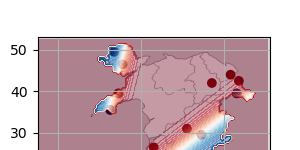

iteration  1
Accuracy is 0.4954816381465103
iteration  2
Accuracy is 0.4975966160353778
iteration  3
Accuracy is 0.5093251297827341
iteration  4
Accuracy is 0.5110555662372621
iteration  5
Accuracy is 0.5116323783887714
iteration  6
Accuracy is 0.5202845606614113
iteration  7
Accuracy is 0.5054797154393386
iteration  8
Accuracy is 0.5047106325706595
iteration  9
Accuracy is 0.4999038646414151
iteration  10
Accuracy is 0.5202845606614113
iteration  11
Accuracy is 0.5237454335704672
iteration  12
Accuracy is 0.5229763507017882
iteration  13
Accuracy is 0.5287444722168814
iteration  14
Accuracy is 0.5220149971159392
iteration  15
Accuracy is 0.508556046914055
iteration  16
Accuracy is 0.5087483176312247
iteration  17
Accuracy is 0.5091328590655643
iteration  18
Accuracy is 0.5075946933282061
iteration  19
Accuracy is 0.5089405883483945
iteration  20
Accuracy is 0.5091328590655643
iteration  21
Accuracy is 0.5129782734089599
experiment:  15


<IPython.core.display.Javascript object>


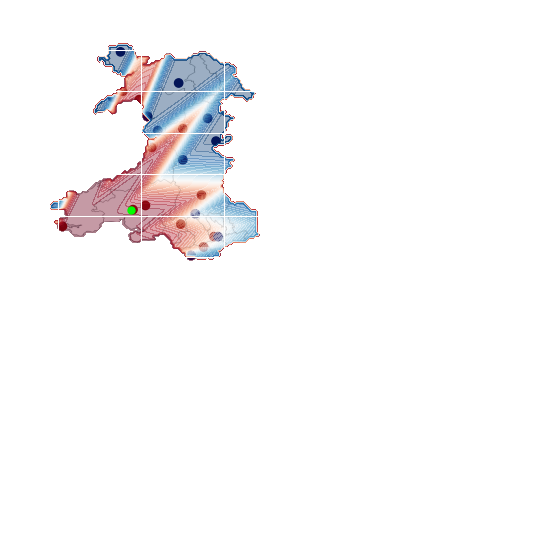

iteration  1
Accuracy is 0.5029801961161315
iteration  2
Accuracy is 0.5189386656412228
iteration  3
Accuracy is 0.5191309363583926
iteration  4
Accuracy is 0.5191309363583926
iteration  5
Accuracy is 0.5193232070755623
iteration  6
Accuracy is 0.5091328590655643
iteration  7
Accuracy is 0.4987502403383965
iteration  8
Accuracy is 0.5027879253989618
iteration  9
Accuracy is 0.5143241684291482
iteration  10
Accuracy is 0.5150932512978273
iteration  11
Accuracy is 0.4891367044799077
iteration  12
Accuracy is 0.48125360507594694
iteration  13
Accuracy is 0.4822149586617958
iteration  14
Accuracy is 0.4770236492982119
iteration  15
Accuracy is 0.4701019034801
iteration  16
Accuracy is 0.47337050567198613
iteration  17
Accuracy is 0.47490867140934434
iteration  18
Accuracy is 0.47567775427802345
iteration  19
Accuracy is 0.48529129013651223
iteration  20
Accuracy is 0.47567775427802345
iteration  21
Accuracy is 0.4681791963084022
experiment:  16


<IPython.core.display.Javascript object>


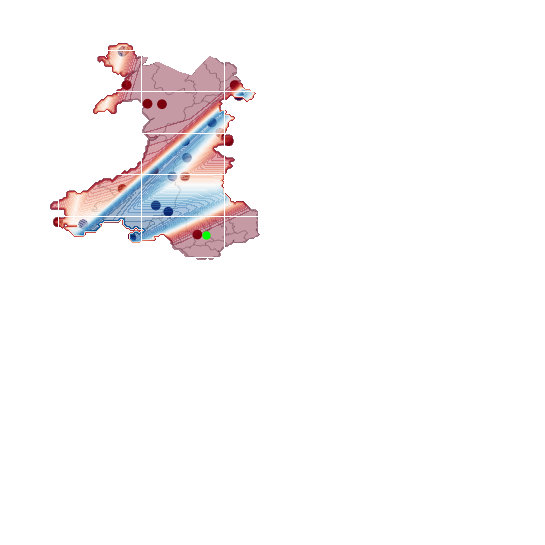

iteration  1
Accuracy is 0.5145164391463181
iteration  2
Accuracy is 0.5141318977119784
iteration  3
Accuracy is 0.5004806767929244
iteration  4
Accuracy is 0.5027879253989618
iteration  5
Accuracy is 0.5108632955200922
iteration  6
Accuracy is 0.5147087098634878
iteration  7
Accuracy is 0.5066333397423572
iteration  8
Accuracy is 0.49259757738896365
iteration  9
Accuracy is 0.49048259950009615
iteration  10
Accuracy is 0.5049029032878293
iteration  11
Accuracy is 0.5024033839646221
iteration  12
Accuracy is 0.5031724668333013
iteration  13
Accuracy is 0.5031724668333013
iteration  14
Accuracy is 0.5037492789848106
iteration  15
Accuracy is 0.49951932320707554
iteration  16
Accuracy is 0.49817342818688715
iteration  17
Accuracy is 0.49894251105556625
iteration  18
Accuracy is 0.5099019419342434
iteration  19
Accuracy is 0.5131705441261296
iteration  20
Accuracy is 0.5127860026917901
iteration  21
Accuracy is 0.5047106325706595
experiment:  17


<IPython.core.display.Javascript object>


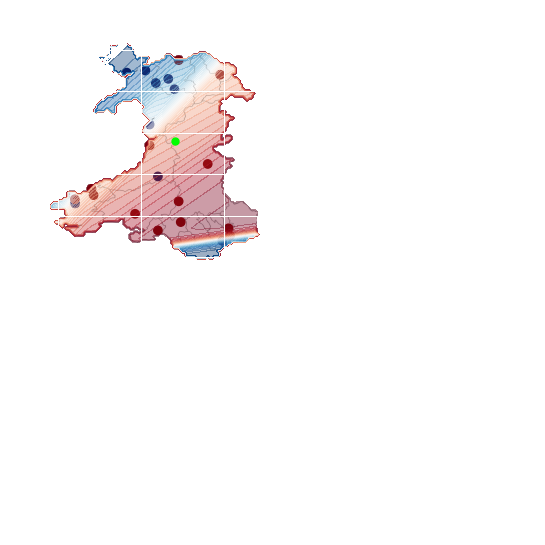

iteration  1
Accuracy is 0.5485483560853682
iteration  2
Accuracy is 0.5114401076716016
iteration  3
Accuracy is 0.4993270524899058
iteration  4
Accuracy is 0.4999038646414151
iteration  5
Accuracy is 0.5029801961161315
iteration  6
Accuracy is 0.48529129013651223
iteration  7
Accuracy is 0.49336666025764275
iteration  8
Accuracy is 0.4875985387425495
iteration  9
Accuracy is 0.5024033839646221
iteration  10
Accuracy is 0.4975966160353778
iteration  11
Accuracy is 0.5020188425302826
iteration  12
Accuracy is 0.4964429917323592
iteration  13
Accuracy is 0.493174389540473
iteration  14
Accuracy is 0.4947125552778312
iteration  15
Accuracy is 0.4895212459142473
iteration  16
Accuracy is 0.5133628148432994
iteration  17
Accuracy is 0.5097096712170737
iteration  18
Accuracy is 0.5039415497019804
iteration  19
Accuracy is 0.5083637761968852
iteration  20
Accuracy is 0.5002884060757546
iteration  21
Accuracy is 0.5020188425302826
experiment:  18


<IPython.core.display.Javascript object>


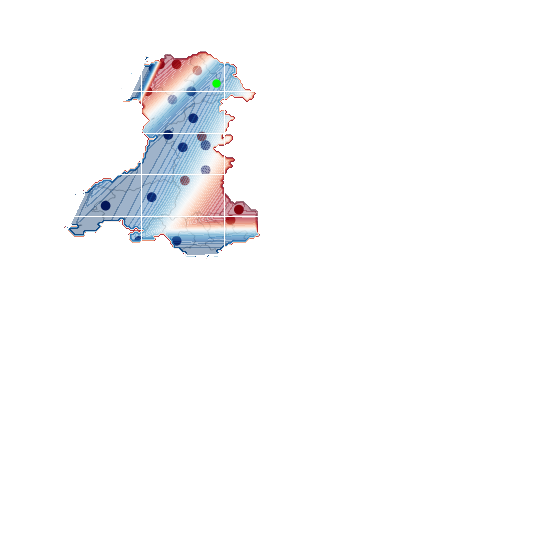

iteration  1
Accuracy is 0.5135550855604691
iteration  2
Accuracy is 0.5412420688329167
iteration  3
Accuracy is 0.5437415881561238
iteration  4
Accuracy is 0.5368198423380119
iteration  5
Accuracy is 0.5348971351663142
iteration  6
Accuracy is 0.5298980965199
iteration  7
Accuracy is 0.531628532974428
iteration  8
Accuracy is 0.5343203230148048
iteration  9
Accuracy is 0.5348971351663142
iteration  10
Accuracy is 0.5427802345702749
iteration  11
Accuracy is 0.5218227263987695
iteration  12
Accuracy is 0.5354739473178235
iteration  13
Accuracy is 0.5172082291866948
iteration  14
Accuracy is 0.5066333397423572
iteration  15
Accuracy is 0.5087483176312247
iteration  16
Accuracy is 0.5020188425302826
iteration  17
Accuracy is 0.5074024226110363
iteration  18
Accuracy is 0.5006729475100942
iteration  19
Accuracy is 0.5054797154393386
iteration  20
Accuracy is 0.5081715054797155
iteration  21
Accuracy is 0.5049029032878293
experiment:  19


<IPython.core.display.Javascript object>


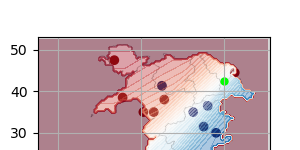

iteration  1
Accuracy is 0.5285522014997116
iteration  2
Accuracy is 0.5287444722168814
iteration  3
Accuracy is 0.5277831186310324
iteration  4
Accuracy is 0.5398961738127284
iteration  5
Accuracy is 0.5425879638531051
iteration  6
Accuracy is 0.5149009805806576
iteration  7
Accuracy is 0.5122091905402807
iteration  8
Accuracy is 0.5325898865602768
iteration  9
Accuracy is 0.5039415497019804
iteration  10
Accuracy is 0.517977312055374
iteration  11
Accuracy is 0.5158623341665064
iteration  12
Accuracy is 0.49567390886368007
iteration  13
Accuracy is 0.5004806767929244
iteration  14
Accuracy is 0.5149009805806576
iteration  15
Accuracy is 0.508556046914055
iteration  16
Accuracy is 0.500865218227264
iteration  17
Accuracy is 0.506825610459527
iteration  18
Accuracy is 0.5012497596616036
iteration  19
Accuracy is 0.4899057873485868
iteration  20
Accuracy is 0.5016343010959431
iteration  21
Accuracy is 0.4972120746010383
experiment:  20


<IPython.core.display.Javascript object>


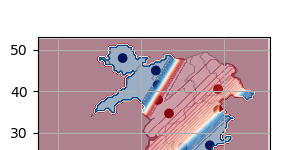

iteration  1
Accuracy is 0.5125937319746202
iteration  2
Accuracy is 0.5097096712170737
iteration  3
Accuracy is 0.5281676600653721
iteration  4
Accuracy is 0.5312439915400884
iteration  5
Accuracy is 0.5241299750048067
iteration  6
Accuracy is 0.5260526821765045
iteration  7
Accuracy is 0.5337435108632955
iteration  8
Accuracy is 0.5379734666410305
iteration  9
Accuracy is 0.535089405883484
iteration  10
Accuracy is 0.5306671793885791
iteration  11
Accuracy is 0.5348971351663142
iteration  12
Accuracy is 0.535858488752163
iteration  13
Accuracy is 0.5329744279946165
iteration  14
Accuracy is 0.533358969428956
iteration  15
Accuracy is 0.5318208036915978
iteration  16
Accuracy is 0.5323976158431071
iteration  17
Accuracy is 0.535858488752163
iteration  18
Accuracy is 0.5360507594693328
iteration  19
Accuracy is 0.5364353009036724
iteration  20
Accuracy is 0.535858488752163
iteration  21
Accuracy is 0.5320130744087676


In [7]:
from random import randint
import time

valid_seeds = [12,15,17,21,23,24,25,31,35,36,37,41,43,45,49,52,55,56,57,58,59]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            eggholderColor(landpoints[value],threshold_low,threshold_high)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], eggholderColor(nextpoint,threshold_low,threshold_high)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 53.80 %
Improvement is = 2.54 %


In [9]:
Results

[[0.50432609113632,
  0.5047106325706595,
  0.50432609113632,
  0.5074024226110363,
  0.5141318977119784,
  0.5160546048836763,
  0.5322053451259373,
  0.5337435108632955,
  0.5193232070755623,
  0.5283599307825418,
  0.5323976158431071,
  0.5356662180349933,
  0.5425879638531051,
  0.5439338588732936,
  0.5427802345702749,
  0.5297058258027303,
  0.5345125937319746,
  0.535089405883484,
  0.5356662180349933,
  0.5314362622572583,
  0.5385502787925399],
 [0.5370121130551817,
  0.5273985771966929,
  0.5270140357623534,
  0.5289367429340511,
  0.5206691020957508,
  0.5210536435300903,
  0.49778888675254757,
  0.5200922899442415,
  0.5212459142472602,
  0.533358969428956,
  0.5175927706210344,
  0.5199000192270717,
  0.5223995385502788,
  0.5139396269948087,
  0.5135550855604691,
  0.520476831378581,
  0.5125937319746202,
  0.5172082291866948,
  0.5191309363583926,
  0.5189386656412228,
  0.5149009805806576],
 [0.49452028456066144,
  0.49951932320707554,
  0.49452028456066144,
  0.4947125

In [10]:
np.savetxt('eggholderRandomnn', Results)